In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory

cudnn.benchmark = True
plt.ion()   # interactive mode

In [10]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'dataset/quick_draw'
image_datasets = datasets.ImageFolder(data_dir,data_transforms['train'])
generator1 = torch.Generator().manual_seed(42)
dataset = torch.utils.data.random_split(image_datasets, [0.7, 0.3], generator1)
image_datasets2 = {'train':dataset[0],'val':dataset[1]}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets2[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}

dataset_sizes = {'train': len(dataset[0]),'val': len(dataset[1])}
class_names = image_datasets.classes
device = torch.device("cuda:0")

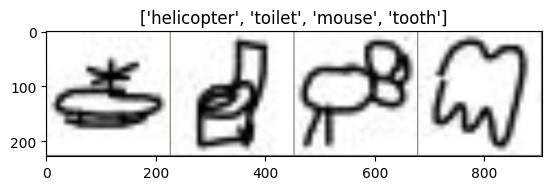

In [11]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [13]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))
    return model

In [14]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [15]:
model_ft = models.resnet18(weights='IMAGENET1K_V1')
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
model_ft.fc = nn.Linear(num_ftrs, 32)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [21]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=5)

Epoch 0/4
----------
train Loss: 0.2451 Acc: 0.9289
val Loss: 0.4136 Acc: 0.8984

Epoch 1/4
----------
train Loss: 0.1937 Acc: 0.9430
val Loss: 0.4233 Acc: 0.9014

Epoch 2/4
----------
train Loss: 0.0894 Acc: 0.9745
val Loss: 0.3814 Acc: 0.9131

Epoch 3/4
----------
train Loss: 0.0635 Acc: 0.9828
val Loss: 0.3840 Acc: 0.9131

Epoch 4/4
----------
train Loss: 0.0525 Acc: 0.9864
val Loss: 0.3990 Acc: 0.9139

Training complete in 83m 48s
Best val Acc: 0.913854


c:\[redacted]\AppData\Local\Temp\ipykernel_9720\1058781594.py:68: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_params_path))


In [1]:
import sys
!{sys.executable} -m pip install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu116


Looking in indexes: https://download.pytorch.org/whl/cu118
  Using cached https://download.pytorch.org/whl/cu118/torch-2.4.0%2Bcu118-cp312-cp312-win_amd64.whl (2692.5 MB)
  Using cached https://download.pytorch.org/whl/cu118/torchvision-0.19.0%2Bcu118-cp312-cp312-win_amd64.whl (5.0 MB)
  Using cached https://download.pytorch.org/whl/cu118/torchaudio-2.4.0%2Bcu118-cp312-cp312-win_amd64.whl (4.0 MB)
  Using cached https://download.pytorch.org/whl/filelock-3.13.1-py3-none-any.whl (11 kB)
  Using cached https://download.pytorch.org/whl/sympy-1.12-py3-none-any.whl (5.7 MB)
  Using cached https://download.pytorch.org/whl/networkx-3.2.1-py3-none-any.whl (1.6 MB)
  Using cached https://download.pytorch.org/whl/fsspec-2024.2.0-py3-none-any.whl (170 kB)
  Using cached https://download.pytorch.org/whl/numpy-1.26.3-cp312-cp312-win_amd64.whl (15.5 MB)
  Using cached https://download.pytorch.org/whl/pillow-10.2.0-cp312-cp312-win_amd64.whl (2.6 MB)
  Using cached https://download.pytorch.org/whl/mpma

In [4]:
import sys
!{sys.executable} -m pip install matplotlib

  Using cached matplotlib-3.9.2-cp312-cp312-win_amd64.whl.metadata (11 kB)
  Using cached contourpy-1.2.1-cp312-cp312-win_amd64.whl.metadata (5.8 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached fonttools-4.53.1-cp312-cp312-win_amd64.whl.metadata (165 kB)
  Using cached kiwisolver-1.4.5-cp312-cp312-win_amd64.whl.metadata (6.5 kB)
  Using cached pyparsing-3.1.2-py3-none-any.whl.metadata (5.1 kB)
Using cached matplotlib-3.9.2-cp312-cp312-win_amd64.whl (7.8 MB)
Using cached contourpy-1.2.1-cp312-cp312-win_amd64.whl (189 kB)
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
Using cached fonttools-4.53.1-cp312-cp312-win_amd64.whl (2.2 MB)
Using cached kiwisolver-1.4.5-cp312-cp312-win_amd64.whl (56 kB)
Using cached pyparsing-3.1.2-py3-none-any.whl (103 kB)


In [23]:
!{sys.executable} -m pip install onnx
!{sys.executable} -m pip install onnxscript

   ---------------------------------------- 0.0/14.4 MB ? eta -:--:--
   ----- ---------------------------------- 2.1/14.4 MB 10.7 MB/s eta 0:00:02
   ---------- ----------------------------- 3.9/14.4 MB 9.8 MB/s eta 0:00:02
   ----------- ---------------------------- 4.2/14.4 MB 10.1 MB/s eta 0:00:02
   -------------- ------------------------- 5.2/14.4 MB 6.4 MB/s eta 0:00:02
   --------------------- ------------------ 7.9/14.4 MB 7.5 MB/s eta 0:00:01
   --------------------------- ------------ 10.0/14.4 MB 8.1 MB/s eta 0:00:01
   ---------------------------------- ----- 12.6/14.4 MB 8.6 MB/s eta 0:00:01
   ---------------------------------------  14.4/14.4 MB 8.8 MB/s eta 0:00:01
   ---------------------------------------- 14.4/14.4 MB 8.5 MB/s eta 0:00:00
   ---------------------------------------- 0.0/660.2 kB ? eta -:--:--
   ---------------------------------------- 660.2/660.2 kB 6.3 MB/s eta 0:00:00


In [17]:
x = torch.randn(1, 3, 224, 224, requires_grad=True).cuda()
torch_out = model_ft(x)

# Export the model
torch.onnx.export(model_ft,               # model being run
                  x,                         # model input (or a tuple for multiple inputs)
                  "resNet18_QD_V1.onnx",   # where to save the model (can be a file or file-like object)
                  export_params=True,        # store the trained parameter weights inside the model file
                  opset_version=10,          # the ONNX version to export the model to
                  do_constant_folding=True,  # whether to execute constant folding for optimization
                  input_names = ['input'],   # the model's input names
                  output_names = ['output']) # the model's output names

In [20]:
baba = ""
for i in class_names:
    baba+= "\"" + i +"\" ,"
print(baba)

"The Eiffel Tower" ,"airplane" ,"ant" ,"banana" ,"bee" ,"book" ,"bus" ,"car" ,"cow" ,"elephant" ,"eyeglasses" ,"helicopter" ,"ice cream" ,"kangaroo" ,"key" ,"moon" ,"mosquito" ,"mountain" ,"mouse" ,"owl" ,"parrot" ,"piano" ,"scissors" ,"toilet" ,"tooth" ,"tractor" ,"traffic light" ,"trumpet" ,"umbrella" ,"whale" ,"wine bottle" ,"wine glass" ,
